导航下载 41204679123
导航下载


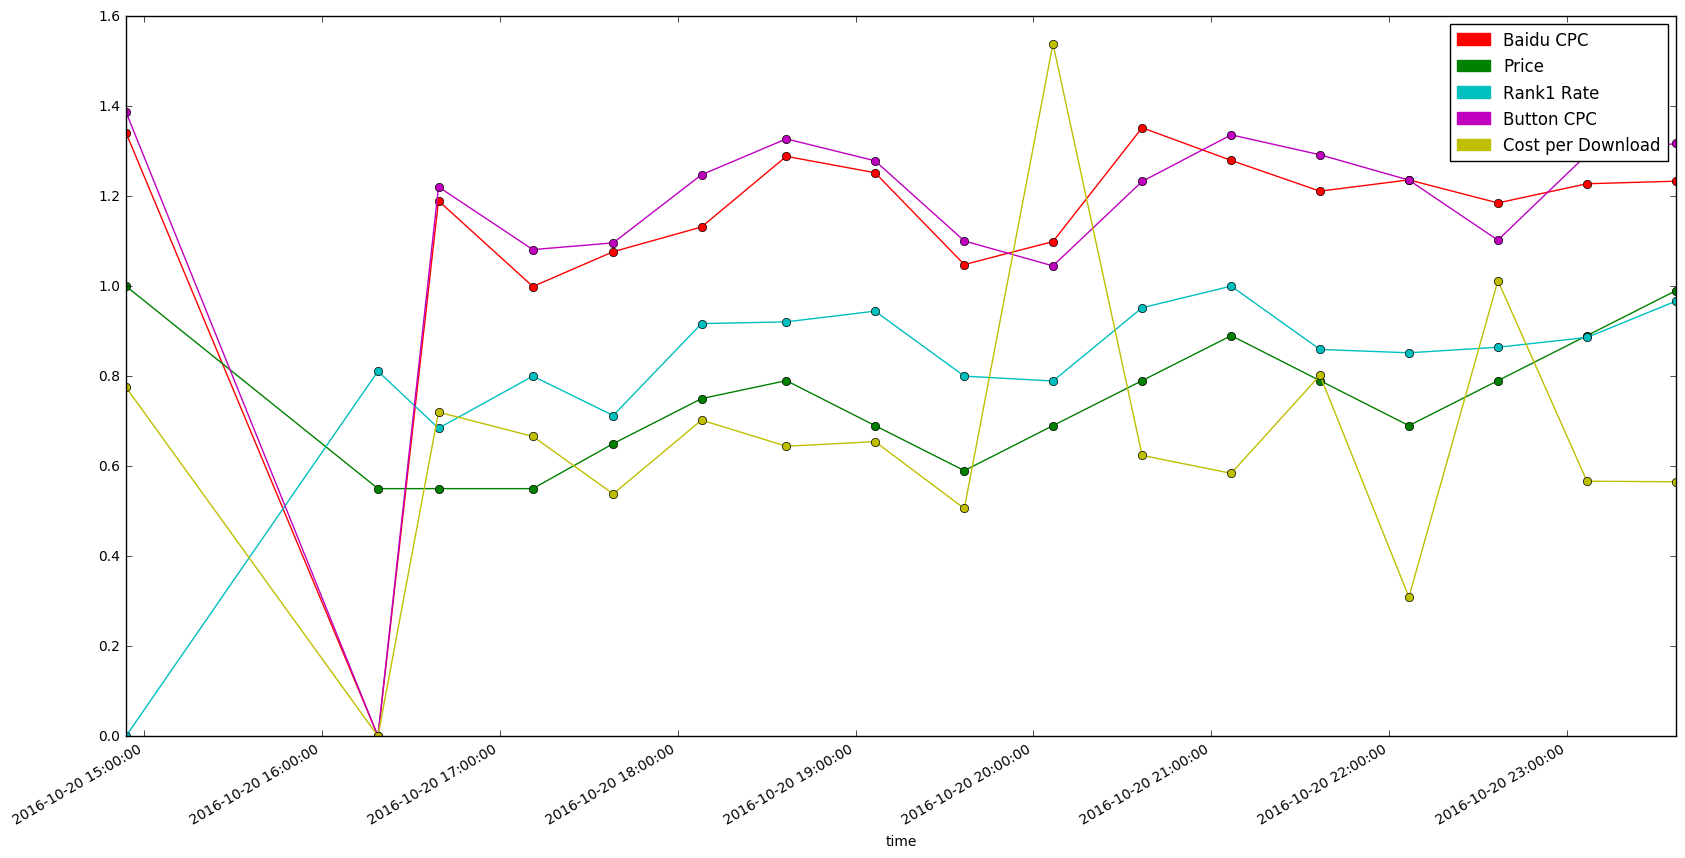

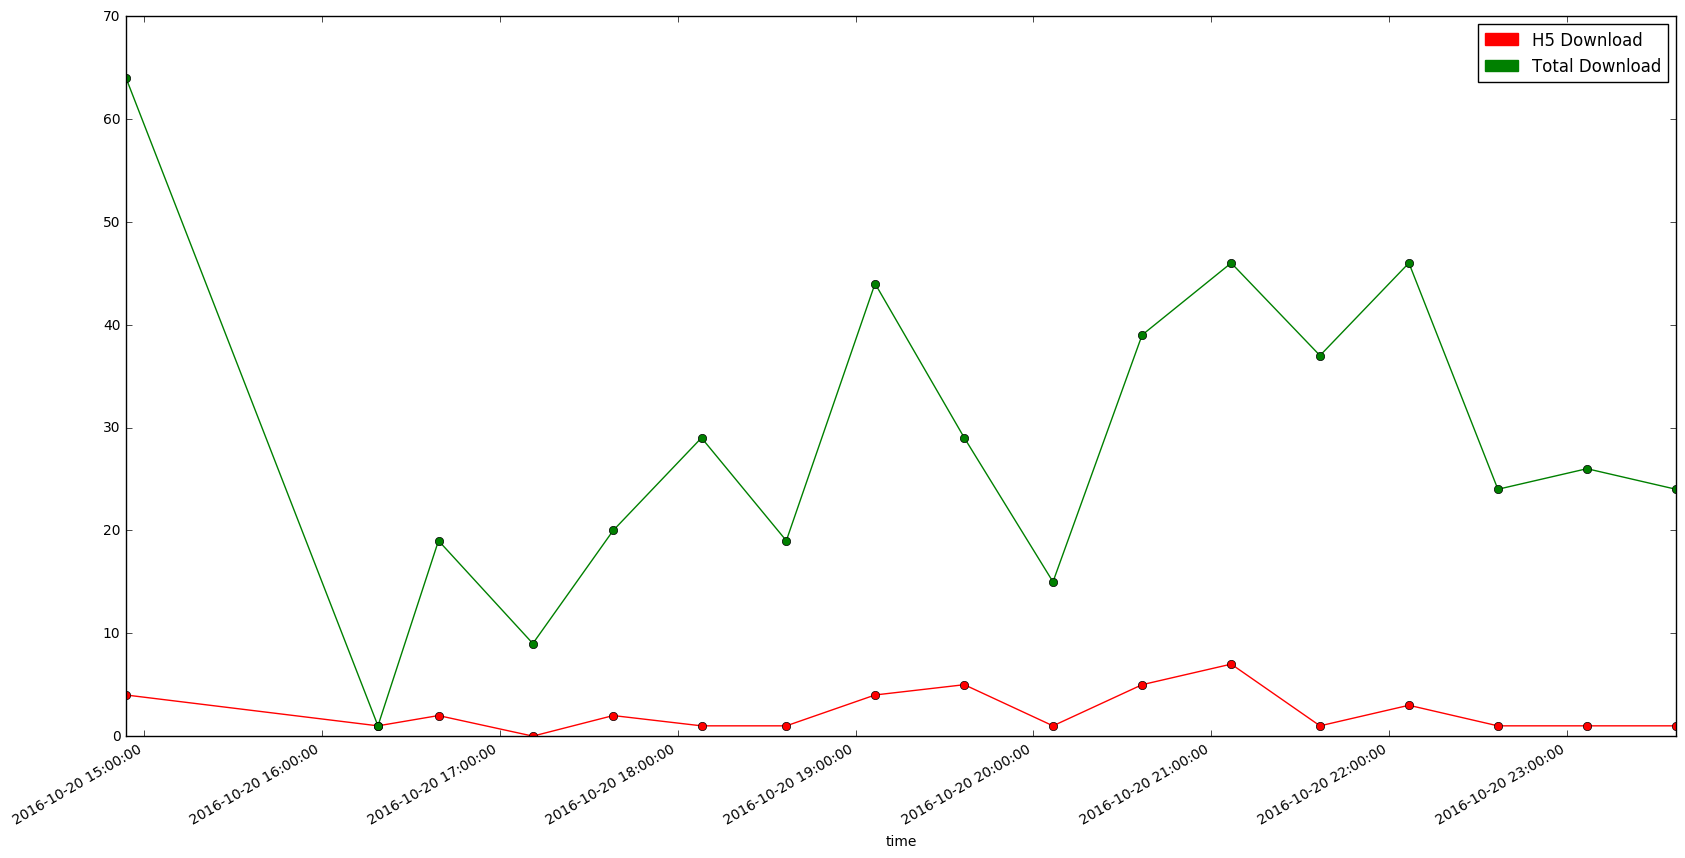

语音导航 41204679138
语音导航


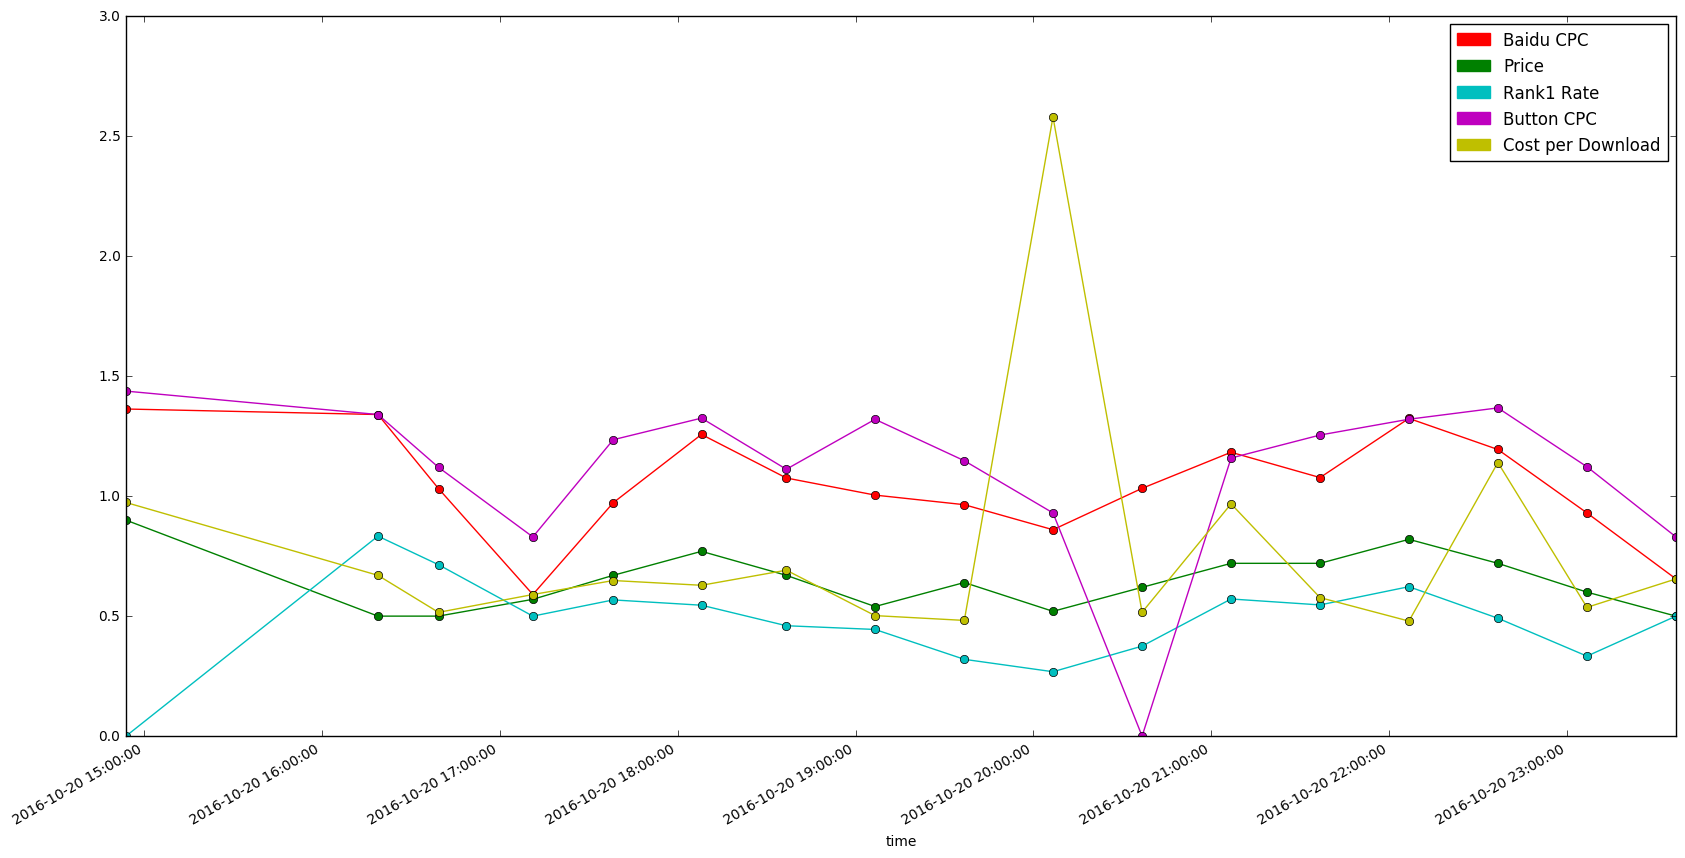

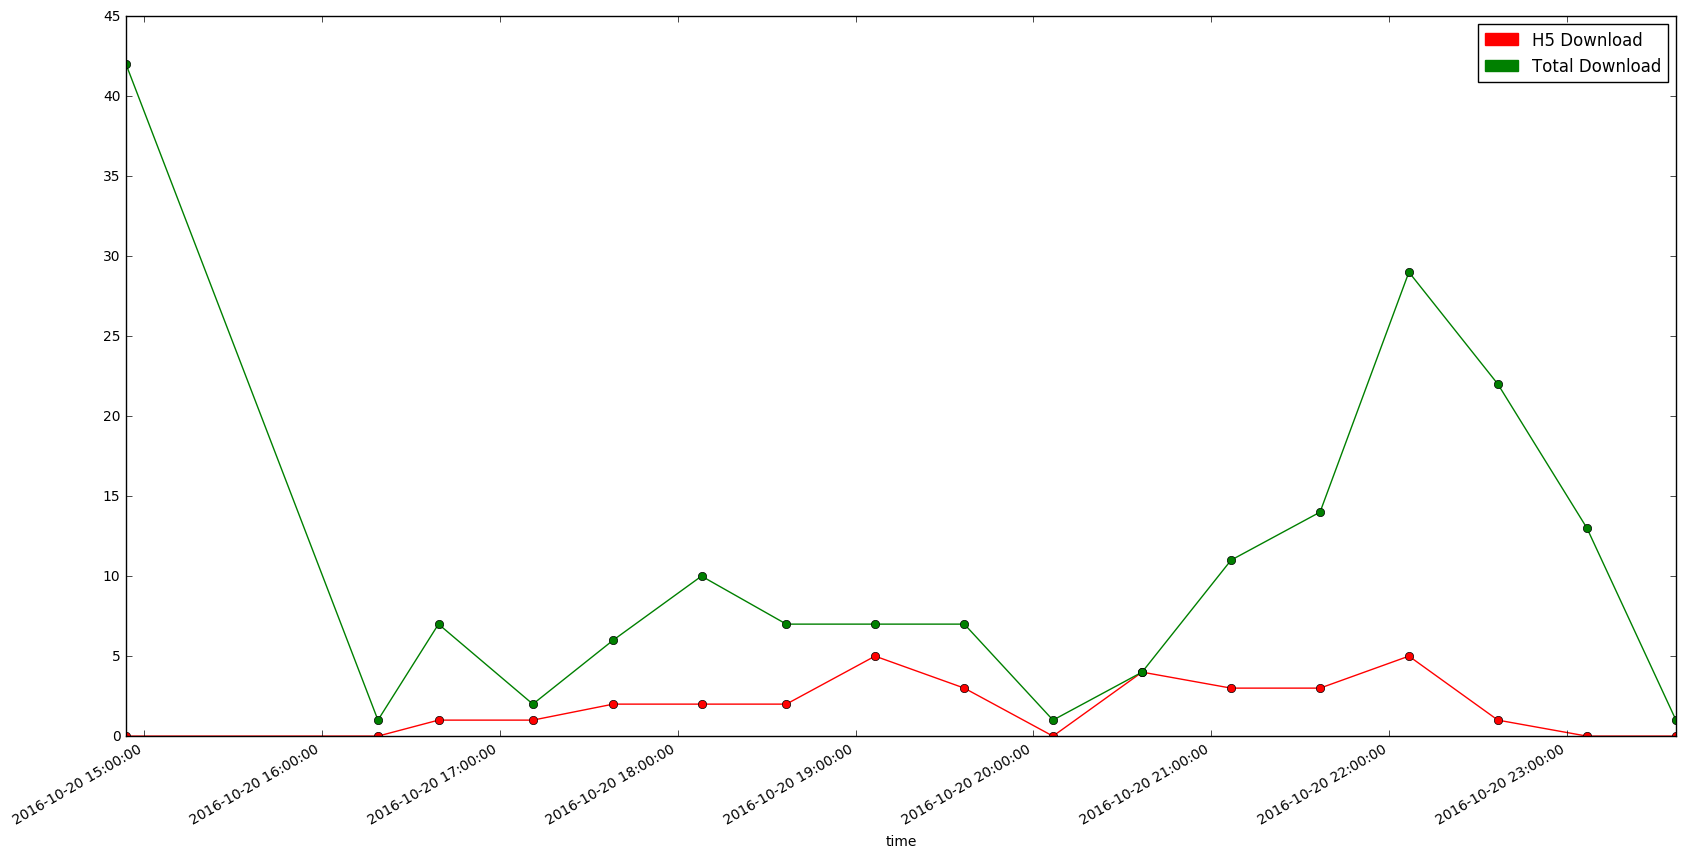

手机导航 41204679141
手机导航


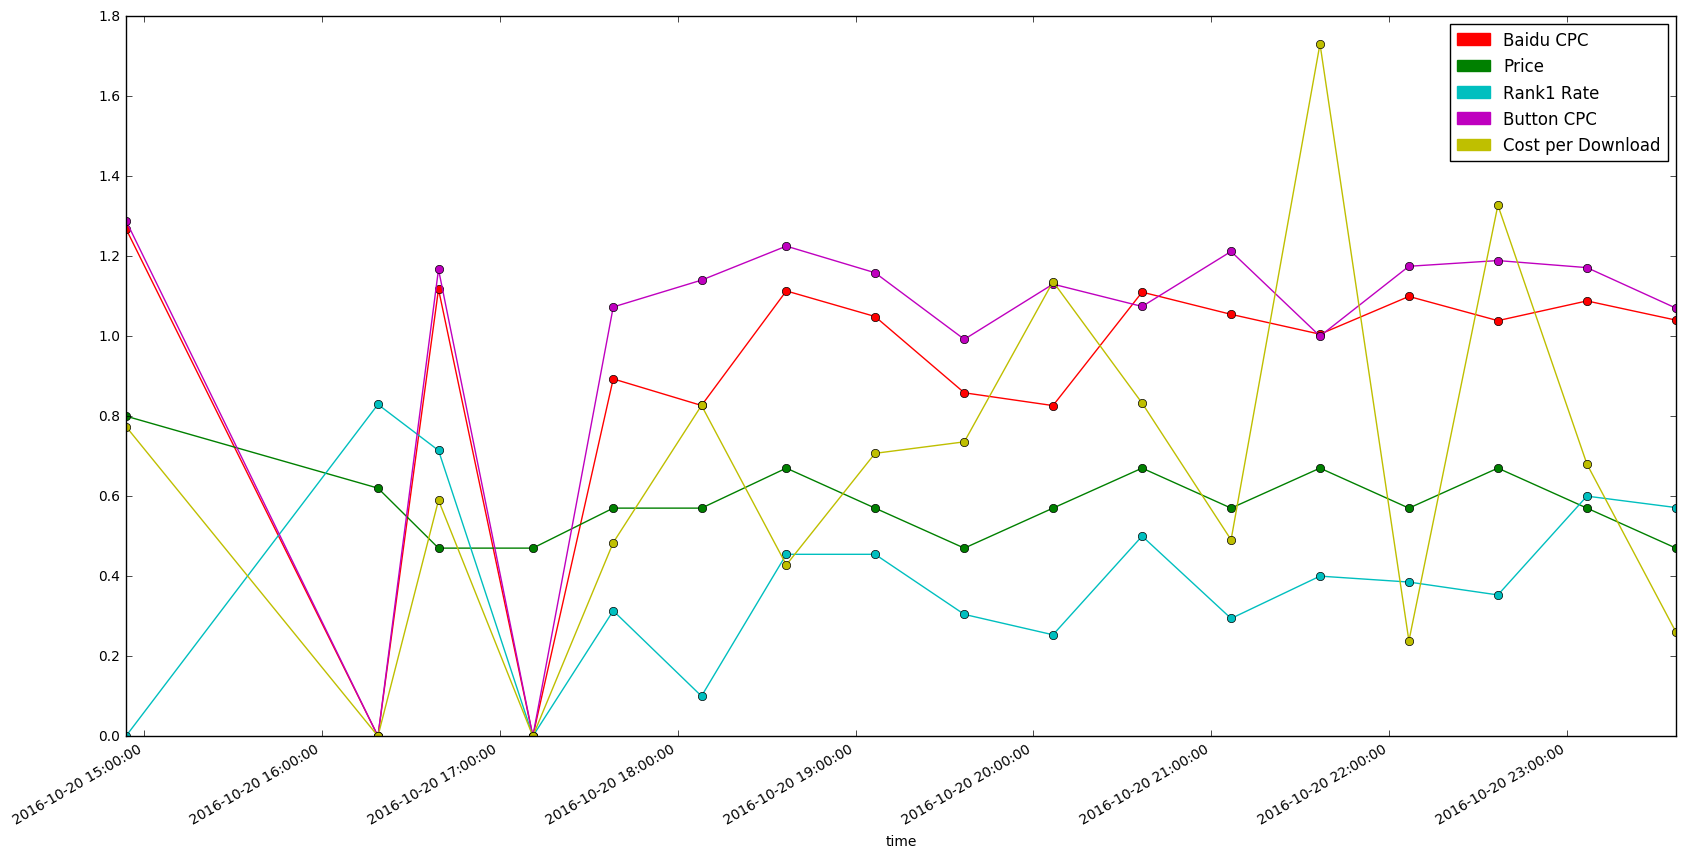

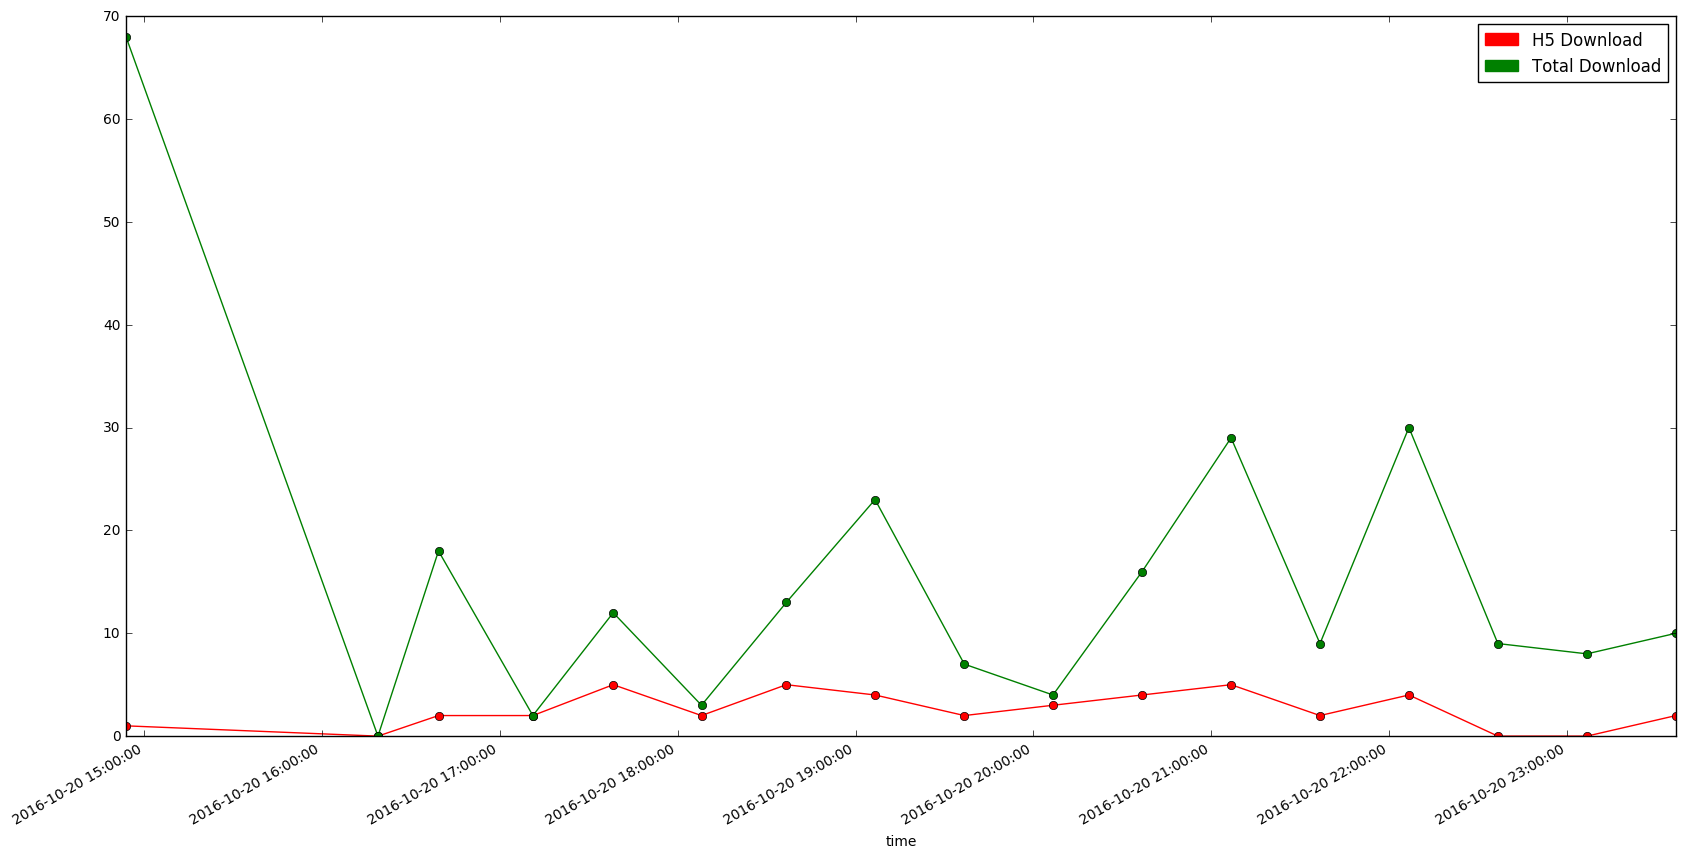

导航地图下载 52066904374


In [ ]:
import pymongo
import json
import requests
import datetime
import csv
import codecs
import pprint

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pymongo import MongoClient

#
#  这个python程序的目的是：
#      1.实时监控调价行为的效果
#      2.查看历史数据（CPC，下载成本，排名，等等）
#      3.导出MongoDB的数据为CSV格式，CSV文件作为训练的输入
#
#

# 显示数据图
SHOW = True

# 显示浩哥的原始数据，列表形式
SHOW_SnapShot = True
SHOW_RangeState = True


# 导出Range数据到CSV文件，然后通过CSV文件进行监督学习
SAVE_TO_CSV = False

pp = pprint.PrettyPrinter(indent=4)

# 设置图标的日期格式
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%Y-%m-%d %H:%M:%S')

# 所有的智能调整的关键词都放在这个全局列表中
# 格式为：
#       APPID, Keyword_id, Keyword_name,is_RTB
WDS = [
    # 高德
    ('b33e77f31fe04969803d8c93eee90701','41204679123','导航下载', True),
    ('b33e77f31fe04969803d8c93eee90701','41204679138','语音导航', True),
    ('b33e77f31fe04969803d8c93eee90701','41204679141','手机导航', True),
    ('b33e77f31fe04969803d8c93eee90701','52066904374','导航地图下载', True),
    ('b33e77f31fe04969803d8c93eee90701','41204679126','手机导航下载', False),
    ('b33e77f31fe04969803d8c93eee90701','52257602639','手机导航地图',False),    
    ('b33e77f31fe04969803d8c93eee90701','41204679597','离线导航',False), 
    ('b33e77f31fe04969803d8c93eee90701','52257602606','手机导航下载',False),
    # 触宝
    ('99f34fe1ac3c472ca60f67296f2dabed','51851122225','有信电话免费下载', True),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683066718','微会下载打电话免费', True),
    ('99f34fe1ac3c472ca60f67296f2dabed','52549511179','移动无限流量', True),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683066700','微会', True),
    ('99f34fe1ac3c472ca60f67296f2dabed','52549510906','移动无限流量卡', True),
    ('99f34fe1ac3c472ca60f67296f2dabed','51662818937','网络电话', False),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683068212','免费电话软件', False),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683068299','免费电话', False),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683067966','网络电话永久免费打', False),
    ('99f34fe1ac3c472ca60f67296f2dabed','51662819099','网络电话软件', False),
]

# 从羽扇后台获取小时Rank
def get_rank(appid, kid, date_str):
    date = date_str.split()[0]
    url = 'http://www.yushanapp.com/baiduapi/kwrank/%s/json/%s/%s/%s' % (appid,kid,date,date)
    #print(url)
    r = requests.get(url)
    data = r.json()
    data_l = data['kws']
    #print(data_l)
    
    for d in data_l:
        if d['date'] == date_str:
            return d['kpis']
    return []
# for debug
#a = get_rank('b33e77f31fe04969803d8c93eee90701','41204679123','2016-10-08 10')
#print(a)

# 获取两个时间的时间差，返回秒数
def get_time_range(t1_str, t2_str):
    t1 = datetime.datetime.strptime(t1_str, '%Y-%m-%d %H:%M:%S')
    t2 = datetime.datetime.strptime(t2_str, '%Y-%m-%d %H:%M:%S')
    if t1.day != t2.day:
        return -1
    return (t2 - t1).total_seconds()


# 正式开始收集数据
#    1.Mongo中的每条纪录可以看成一个Snapshot(快照)，代表该关键词在当前时刻的状态，
#      包括百度后台的数据、附加创意、落地页系统的数据。
#    2.Snapshot的间隔是20分钟左右，也就是调价和收集数据的频率。=
#    3.然后基于两个相邻的Snapshot，做减法，得到一个RangeState，代表这二十分钟内的效果
#    4.我们的数据图基于RangeState作为散点
with MongoClient('mongodb://101.200.174.136:10222') as client:
    client.yushan.authenticate('yushan','yushan')
    db = client.yushan
    c = db['baidu_fjcy']
    
    # for debug
    #tmp = c.find_one()
    #pp.pprint(tmp)
    #print(json.dumps(c.find_one(), indent=4))

                
    for (appid,kid,kname,rtb) in WDS:
        
        if not rtb:
            continue
        # 数据文件初始化
        if SAVE_TO_CSV:
            fname = '%s.csv' % kid
            csvfile = codecs.open(fname,"w+", "utf8")
            spamwriter = csv.writer(csvfile,quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(['changeid',
                            'keyword',
                            'keywordid',
                            'time',
                            'hour',
                            'price',
                            'rank1rate',
                            'cpc',
                            'hourclick'
                           ])
                 
        data_ori = []
        print(kname,kid)
        for i in c.find({'kw_id':kid}):
            time_created = i['date']
            
            # 跳过无效数据
            if type(time_created) == datetime.datetime:
                continue
            if 'rank_report' not in i or 'kw_cost_report' not in i:
                continue
            if type(i['rank_report']) == dict:
                    continue
                    
            # 查看某一天的数据，调试用
            if time_created.startswith('2016-10-20'):
                pass
            else:
                continue
            
            # 如果要通过百度后台获取rank值，请设置为True
            if False:
                date_str = time_created.split(':')[0]
                ranks = get_rank(appid, kid, date_str)
                if not ranks:
                    continue
                else:
                    ranks_new = i['rank_report']
                    
                    ranks_1 = {}
                    ranks_1['date'] = date_str
                    ranks_1['kpis'] = ranks
                    ranks_new.append(ranks_1)
                    #i['rank_report']['kpis'][-1] = ranks
                    c.find_one_and_update({'_id': i['_id']}, {'$set': {'rank_report': ranks_new}})

                    ranks = ranks
                    #pp.pprint(result)
            else:
                if type(i['rank_report'][-1]) == dict:
                    ranks = i['rank_report'][-1]['kpis']
                else:
                    continue
            
            # convert time_str to datetime
            dt = datetime.datetime.strptime(time_created,'%Y-%m-%d %H:%M:%S')
            
            # 查看浩哥的原始数据
            if SHOW_SnapShot and False:
                print('original: ',i['price_report']['keyword'],
                  i['date'],
                  i['price_report']['price'],
                  i['fujia_report']['button']['展现'],
                  i['fujia_report']['button']['点击'],
                  i['fujia_report']['button']['消费'],
                  i['fujia_report']['button']['点击率'],
                  i['fujia_report']['button']['平均点击价格'],
                  ranks,
                  i['price_report']['mobileQuality'],
                 )
                print(i)
                print('\n')
            
            #
            # 将需要的字段汇总到一个元组中
            #
            data_ori.append({
                    'time_created':time_created,
                    'time_dt':dt,
                    'price': i['price_report']['price'], # 出价
                    'btn_impression': i['fujia_report']['button']['展现'],
                    'btn_click': i['fujia_report']['button']['点击'],
                    'btn_cost': i['fujia_report']['button']['消费'],
                    'btn_avg_price': i['fujia_report']['button']['平均点击价格'],
                    'baidu_impression': int(i['kw_cost_report']['kpis'][0]['impression']) if 'kw_cost_report' in i else 0,
                    'baidu_click': int(i['kw_cost_report']['kpis'][1]['click']) if 'kw_cost_report' in i else 0,
                    'baidu_cost': float(i['kw_cost_report']['kpis'][2]['cost']) if 'kw_cost_report' in i else 0,
                    'h5_dl': int(i['h5dl_report']['Android']) + int(i['h5dl_report']['iOS']) if 'h5dl_report' in i else 0,
                    'rank0': ranks[0],
                    'rank1': ranks[1],
                    'rank2': ranks[2],
                    'rank3': ranks[3],
                    'rank4': ranks[4],
                    'kw_name': i['price_report']['keyword'],
                    'kw_id': i['price_report']['keywordId'],
                    'kw_chuangyi': i['price_report']['campaignId'],
                    'kw_danyuan': i['price_report']['adgroupId'],
                    'kw_match': i['price_report']['matchType'],
                    'kw_quality': i['price_report']['mobileQuality'],
                 })
            
        # for now, data_ori is all the datas for one keyword
        if len(data_ori) < 2:
            continue
        
        #
        # 接下来，我们把两个相邻的SnapShot做减法，得到一个RangeState，也就是我们训练的点
        #
        change = []
        price = []
        rank1 = []
        
        baidu_impression = []
        baidu_click = []
        baidu_cost = []
        baidu_cpc = []
        hour_baidu_click = []
        
        btn_impression = []
        btn_click = []
        btn_cost = []
        btn_cpc = []
        btn_avg_price = []
        hour_btn_click = []
        
        dl_h5 =[]
        dl_total = []
        cost_per_dl = []
        
        hour =[]
        dates =[]

        
        # 打印出关键词名
        print(data_ori[0]['kw_name'])
        
        # 从最新的纪录开始，倒序便利列表，相邻的点做减法。
        # 如果两个点不在同一天，跳过。
        i = len(data_ori)-1
        while i > 0:
            d_cur = data_ori[i]
            d_pre = data_ori[i-1]
            
            # 如果百度展现相同，代表停投了，跳过
            if d_cur['baidu_impression'] == d_pre['baidu_impression']:
                i -= 1
                continue
            
            # 设置为前一点的状态
            i_time = d_pre['time_created']
            i_price = d_pre['price']            
            i_keyword = d_pre['kw_name']
            i_kid = int(d_pre['kw_id'])
            i_quality = d_pre['kw_quality']
            i_time_hour = i_time.split(':')[-3].split()[1]
            
            # 需要做减法才能得到的状态
            # 时间差
            i_time_range = get_time_range(d_pre['time_created'],d_cur['time_created'])           
            if i_time_range == -1:
                i -= 1
                continue
                
            # 百度后台的总数据，即：包括附加创意
            i_baidu_impression = d_cur['baidu_impression'] - d_pre['baidu_impression']
            i_baidu_click = d_cur['baidu_click'] - d_pre['baidu_click']
            i_baidu_cost= d_cur['baidu_cost'] - d_pre['baidu_cost']
            i_baidu_cpc = i_baidu_cost / i_baidu_click if i_baidu_click != 0 else 0
            
            i_baidu_impression_increase_rate = i_baidu_impression / d_pre['baidu_impression'] if d_pre['baidu_impression'] != 0 else 0
            i_baidu_click_increase_rate = i_baidu_click / d_pre['baidu_click'] if d_pre['baidu_click'] != 0 else 0
            i_baidu_cost_increase_rate = i_baidu_cost / d_pre['baidu_cost'] if d_pre['baidu_cost'] != 0 else 0            
            
            # 按钮的数据，来自附加创意报告
            i_btn_impression = d_cur['btn_impression'] - d_pre['btn_impression']
            i_btn_click = d_cur['btn_click'] - d_pre['btn_click']
            i_btn_cost= d_cur['btn_cost'] - d_pre['btn_cost']
            i_btn_cpc = i_btn_cost / i_btn_click if i_btn_click != 0 else 0
            i_btn_avg_price = d_cur['btn_avg_price']
            
            i_btn_impression_increase_rate = i_btn_impression / d_pre['btn_impression'] if d_pre['btn_impression'] != 0 else 0
            i_btn_click_increase_rate = i_btn_click / d_pre['btn_click'] if d_pre['btn_click'] != 0 else 0
            i_btn_cost_increase_rate = i_btn_cost / d_pre['btn_cost'] if d_pre['btn_cost'] != 0 else 0            
                        
            # H5下载次数，来自落地页系统
            i_h5_dl = d_cur['h5_dl'] - d_pre['h5_dl']
            i_dl_total = i_h5_dl + i_btn_click
            i_cost_per_dl = (i_baidu_cost / i_dl_total) / 2 if i_dl_total != 0 else 0
            
            # 如果按照该Range的状态，那么，算出每小时的量，便于比较，原因是，不是每次range的长度都正好是20分钟
            i_hour_baidu_click = (i_baidu_click * 60 ) / i_time_range
            i_hour_btn_click = (i_btn_click * 60 ) / i_time_range
            
            # rank1_rate
            if int(d_cur['rank4']) != 0:
                i_rank1_rate = float(int(d_cur['rank0']) / int(d_cur['rank4']))
            else:
                i_rank1_rate = 0
                                
            if False:
                print('RangeState: ',
                      i_keyword,
                      i_kid,
                      i_time,
                      i_time_hour,
                      i_price,
                      i_rank1_rate,
                      i_baidu_cpc,
                      i_hour_baidu_click,
                     )
                print(i)
                
            # to do
            if SAVE_TO_CSV:
                spamwriter.writerow([
                        i,
                        i_keyword,
                        i_kid,
                        i_time,
                        i_time_hour,
                        i_price,
                        i_rank1_rate,
                        i_cpc,
                        i_hour_click,
                ])
   
            if SHOW:
                change.append(i)                
                price.append(i_price)
                rank1.append(i_rank1_rate)
                
                baidu_cpc.append(i_baidu_cpc)
                baidu_impression.append(i_baidu_impression)
                baidu_click.append(i_baidu_click)
                baidu_cost.append(i_baidu_cost) 
                hour_baidu_click.append(i_hour_baidu_click)
                
                
                btn_impression.append(i_btn_impression)
                btn_click.append(i_btn_click)
                btn_cost.append(i_btn_cost)
                btn_cpc.append(i_btn_cpc)   
                btn_avg_price.append(i_btn_avg_price)
                hour_btn_click.append(i_hour_btn_click)
                
                dl_h5.append(i_h5_dl)
                dl_total.append(i_dl_total)
                cost_per_dl.append(i_cost_per_dl)
                
                hour.append(i_time_hour)
                dates.append(d_pre['time_dt'])
            
            i -= 1
            
        # pyplot time
        #pydates = matplotlib.dates.date2num(dates)
                
        # then show the graph
        #print('aaaa',price)
        #print(pydates)
        if SHOW:
            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 20
            fig_size[1] = 9
            plt.rcParams["figure.figsize"] = fig_size
                
            if True:               
                line1 = plt.plot(dates, baidu_cpc,'o-r')
                line2 = plt.plot(dates, price,'o-g')
                line3 = plt.plot(dates, rank1,'o-c')
                line4 = plt.plot(dates, btn_cpc,'o-m')
                line5 = plt.plot(dates, cost_per_dl, 'o-y')

                
                plt.xlabel('time')
                
                le1 = mpatches.Patch(color='red', label='Baidu CPC')
                le2 = mpatches.Patch(color='green', label='Price')
                le3 = mpatches.Patch(color='c', label='Rank1 Rate')
                le4 = mpatches.Patch(color='m', label='Button CPC')
                le5 = mpatches.Patch(color='y', label='Cost per Download')

                plt.legend(handles=[le1,le2,le3,le4,le5])
                
                plt.gcf().autofmt_xdate(bottom=0.1, rotation=30, ha='right')
                plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
                
                plt.show()
            if True:
                line1 = plt.plot(dates, dl_h5,'o-r')
                line2 = plt.plot(dates, dl_total,'o-g')
                
                plt.xlabel('time')
                
                le1 = mpatches.Patch(color='red', label='H5 Download')
                le2 = mpatches.Patch(color='green', label='Total Download')

                plt.legend(handles=[le1,le2])
                
                plt.gcf().autofmt_xdate(bottom=0.1, rotation=30, ha='right')
                plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
                
                plt.show()
                
            if False:
                plt.plot(rank1, cpc,'ob')
                plt.xlabel('rank1_rate')
                plt.ylabel('cpc')
                plt.show()
            if False:
                plt.plot(hour, cpc,'ob',hour, price,'og',hour, rank1,'or')
                plt.xlabel('change')
                #plt.ylabel('cpc')
                plt.show()
        #break
        if SAVE_TO_CSV:
            csvfile.close()
        ### end for loop